In [ ]:
# impoting the libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas_datareader.data as web
import datetime as dt
import sklearn
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
import bs4 as bs
import urllib.request as urlb
import pickle
import requests
import os
import time
#import mpld3
%matplotlib notebook

#mpld3.enable_notebook()
style.use('ggplot')

In [ ]:
# asigning the start date and end date 
start = dt.datetime(1985, 1, 1) # collect from this date
end = dt.datetime.today() #to this date.
stock  = 'AAPL' #using Apple's stock data
df = web.DataReader(stock,'yahoo',start,end) #fetches the data from Yahoo and stores it in data.

In [ ]:
df.head()

In [ ]:
df = df.rename(columns = {'Adj Close':'adj_close'})

In [ ]:
df.head()

In [ ]:
df.to_csv('AAPL.csv')

In [ ]:
data = pd.read_csv('AAPL.csv', parse_dates=True, index_col=0)

In [ ]:
data.head()

In [ ]:
%matplotlib notebook
data[['adj_close','High','Low','Open','Close']].plot()
plt.title("Stock Prices")

# Rolling average method.

In [ ]:
#creating a new column to add rolling average

#data['100ma'] = data['adj_close'].rolling(window=100).mean()

In [ ]:
#data.tail()

In [ ]:
#THe first 100 rows cant have the calculation.
#data.head()

In [ ]:
#data.dropna(inplace=True)

In [ ]:
#the first 100 rows will be deleted due to dropna
#data.head()

In [ ]:
#data.tail()

In [ ]:
# %matplotlib notebook

# #visualiziation
# ax1 = plt.subplot2grid((6,1), (0,0),rowspan=5,colspan=1)
# ax2 = plt.subplot2grid((6,1), (5,0),rowspan=1,colspan=1, sharex=ax1)

# ax1.plot(data.index,data['adj_close'])
# ax1.plot(data.index,data['100ma'])
# ax2.bar(data.index,data['Volume'])

# plt.show();

# Resampling the data.

In [ ]:
data_ohlc=data['adj_close'].resample('10D').ohlc()#creates open high low close
data_volume= data['Volume'].resample('10D').sum()
data_ohlc.head()

In [ ]:
data_ohlc.reset_index(inplace=True)

In [ ]:
#candlestick_ohlc requires mdates and ohlc.
data_ohlc['Date'] = data_ohlc['Date'].map(mdates.date2num)


In [ ]:
data_ohlc.head()

In [ ]:
%matplotlib notebook

#visualiziation
ax1 = plt.subplot2grid((6,1), (0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0),rowspan=1,colspan=1, sharex=ax1)

ax1.xaxis_date()#this is to display actual dates in graph

candlestick_ohlc(ax1,data_ohlc.values,width=5,colorup='g')
ax2.fill_between(data_volume.index.map(mdates.date2num),data_volume.values,0)

plt.show();

## Using beautiful Soup to fetch S&P 500 companies from wikipedia.
- import beautifulsoup4 library
- use pickle to serialize any python object, this is used to save the S&P 500 list so as to avoid going back to wikipedia everytime it is needed.
- fetch the data

In [ ]:
def sp500():
    res = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(res.text,'lxml')
    table = soup.find('table',{'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text #we need the first column which contains the tickers
        tickers.append(ticker)
    with open('sp500tickers.pickle',"wb")as f:
        pickle.dump(tickers,f)#dumping tickers to file 'f'
        print(tickers)
    return tickers
sp500()

    Gettitng the data of all the companies we just fetched from wikipedia
    - pull stock pricing data on all of the comapnies acquired
    - if we chose to reload the data, the program will pull the stock information from wikipedia again. But we will be storing the data as a pickle object, and will be storing the data on our local system as the data will be fetched frequently, this makes it more efficient.
    - Using the datetime function for pandas to specify dates for pandas.
    - os is used to creaete, edit and delete files on the system.'
    - Since I am unable to use the yahoo finance or google api to fetch historical data, I am using robinhood, it return the data from last year till today.

In summary we are parsing the data once from the website and storing it locally. Time being another factor, as it takes quite some time to fetch the data again from the internet, storing the data locally provides faster data access.

In [ ]:
'''If reload is true then the fuction will reload the tickers from wikipedia
else it will fetch the list of tickers from the pickle object '''

def get_data(reload = False):
    if reload:
        tickers = sp500()
    else:
        with open("sp500tickers.pickle","rb") as f:
            tickers = pickle.load(f)
    #create a folder to save the csv files using OS
    if not os.path.exists('stock_dfs'):
            os.mkdir('stock_dfs')
    #fetching the historical stock price.    
    start = dt.datetime(2000,1,1)
    end = dt.datetime.now()
    #iterating over the tickers to fectch the data for those in the list
    for ticker in tickers:
        print(ticker)
        #is the csv file doesnt exist in the folder create one else acknowledge its existance
        if not os.path.exists('stock_dfs\{}.csv'.format(ticker)):
            df = web.DataReader(ticker,'yahoo',start,end)
            df.reset_index(inplace=True)
            df.set_index("Date",inplace=True)
            df.to_csv('stock_dfs\{}.csv'.format(ticker))
        else:
            print("Alerady have {}".format(ticker))
get_data()          

Further we combine all the dataset into one dataframe

In [24]:
def compile_data():
    with open("sp500tickers.pickle","rb") as f:
        tickers = pickle.load(f)
    
    main_df = pd.DataFrame()
    
    for count,ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        
#         df['{}_HL_pct_diff'.format(ticker)] = (df['High'] - df['Low']) / df['Low']
#         df['{}_daily_pct_chng'.format(ticker)] = (df['Close'] - df['Open']) / df['Open']
        
        df.rename(columns = {'Adj Close':ticker},inplace=True)
        df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df,how='outer')
            
        if count % 10==0:
            print(count)
    print(main_df.head(50))
    main_df.to_csv('sp500_combo_adjc.csv')
    
compile_data()

310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
                  MMM       ABT  ABBV       ABMD  ACN      ATVI       ADBE  \
Date                                                                         
2000-01-03  27.668850  6.730005   NaN  18.250000  NaN  1.245554  16.145748   
2000-01-04  26.569431  6.537722   NaN  17.812500  NaN  1.207666  14.791295   
2000-01-05  27.339037  6.525703   NaN  18.000000  NaN  1.212402  15.083735   
2000-01-06  29.537876  6.754039   NaN  18.031250  NaN  1.188722  15.206868   
2000-01-07  30.124239  6.826150   NaN  17.937500  NaN  1.221874  15.945663   
2000-01-10  29.977655  6.778075   NaN  20.500000  NaN  1.283441  16.561329   
2000-01-11  29.464573  6.681936   NaN  19.812500  NaN  1.340273  15.422350   
2000-01-12  29.537876  6.621902   NaN  19.593750  NaN  1.283441  15.345394   
2000-01-13  29.537876  6.561151   NaN  21.000000  NaN  1.297649  16.161148   
2000-01-14  29.116436  6.706955   NaN  21.375000  NaN  1.28344

##### What is a correlation?<br>
A correlation is a statistical test of association between variables that is measured on a -1 to 1 scale. The closer the correlation value is to -1 or 1 the stronger the association, the closer to 0, the weaker the association. It measures how change in one variable is associated with change in another variable.
<br>
There are a few common types of tests to measure the level of correlation, Pearson, Spearman, and Kendall. Each have their own assumptions about the data that needs to be meet in order for the test to be able to accurately measure the level of correlation. These are discussed further in the post. Each type of correlation test is testing the following hypothesis.

Source: https://pythonfordatascience.org/correlation-python/

Finding correlations in the dataframe.
- there are a lot of missing values  
- attempting to look for some relationships in the dataset
- data are more than 17 years old
- the companies might have changed over the course of this period

**Perfect negative correlation** **(-1)** exists when the two securities move in opposite directions (i.e., stock A moves up and stock B moves down).<br>
**Perfect positive correlation** **(+1)** exists if the two securities move in perfect unison (i.e., stock A and stock B move up and down at the same time).<br>
**No correlation** **(0)** exists if the price movements are completely random (stock A and stock B go up and down randomly). (For more, see: What Does it Mean if the Correlation Coefficient is Positive, Negative or Zero?)

Source:https://www.investopedia.com/university/guide-pairs-trading/pairs-trading-correlation.asp

In [25]:
def visuals():
    df = pd.read_csv("sp500_combo_adjc.csv")
#     df['AAPL'].plot()
#     plt.show()
    df_corr = df.corr()
    df_corr.to_csv('sp500corr.csv')
    # fetching just the values
    data1 = df_corr.values
    #creating a figure
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    #defining color for the heatmap
    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)
    #creating ticks
    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    #inverting the graph for more readability
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    #naming the ticks
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1,1)
    plt.tight_layout()
    plt.savefig('correlation.png',dpi=(600))
    plt.show()
    

<IPython.core.display.Javascript object>


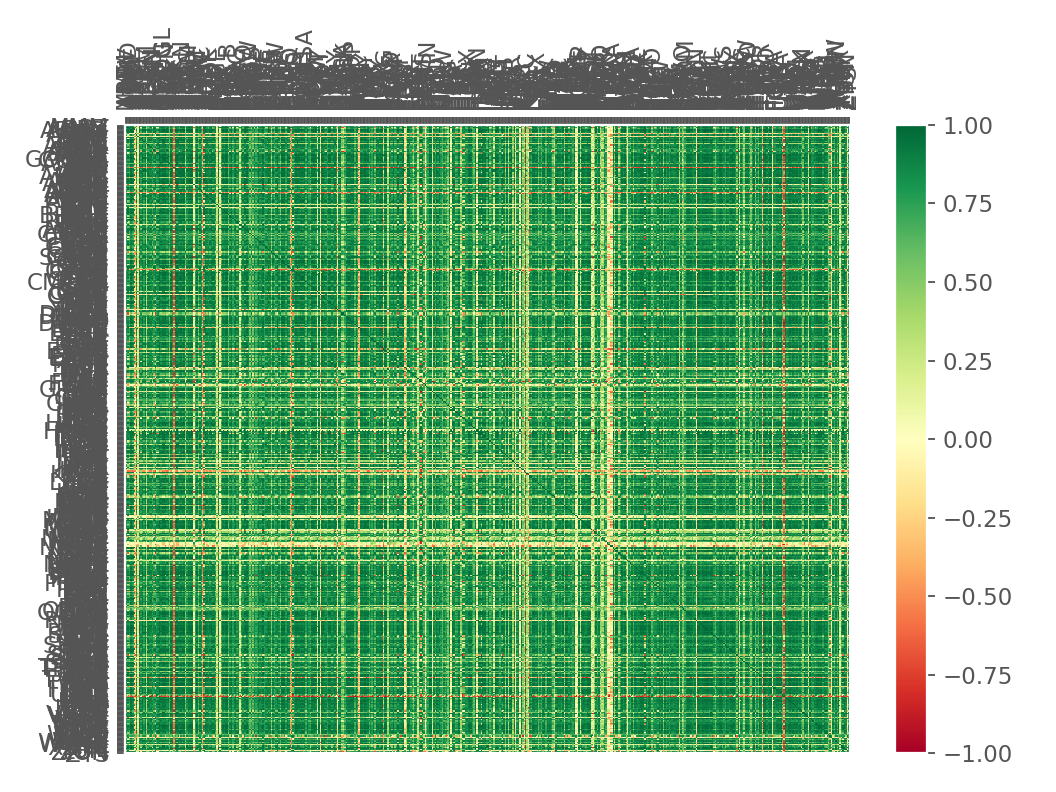

In [26]:
visuals()

Data preprocessing for Machine Learning:
- Build a model that will predict the price for tomorrow by considering the price change today.
- Create feature set and Labels(target) to feed the machine learning model.
- Feature will be the price change for all the companies that day. Target will be 'Buy','Sell','Hold'
- The idea is to train our model to predict the  to buy a particular comapany's share in case of 2% rise in the percentage in the next 7 days, else if the percentage change drops below 2% then sell the stock, if no significant change is observed then hold the stock


Creating labels

In [27]:
def process_label(ticker):
    days = 7
    df = pd.read_csv('sp500_combo_adjc.csv',index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1,days+1):
        df['{}_{}'.format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
        
    df.fillna(0,inplace=True)
    df.to_csv('temp.csv')
    return ticker,df

In [28]:
process_label('XOM')

('XOM',                    MMM        ABT       ABBV        ABMD         ACN  \
 Date                                                                   
 2000-01-03   27.668850   6.730005   0.000000   18.250000    0.000000   
 2000-01-04   26.569431   6.537722   0.000000   17.812500    0.000000   
 2000-01-05   27.339037   6.525703   0.000000   18.000000    0.000000   
 2000-01-06   29.537876   6.754039   0.000000   18.031250    0.000000   
 2000-01-07   30.124239   6.826150   0.000000   17.937500    0.000000   
 2000-01-10   29.977655   6.778075   0.000000   20.500000    0.000000   
 2000-01-11   29.464573   6.681936   0.000000   19.812500    0.000000   
 2000-01-12   29.537876   6.621902   0.000000   19.593750    0.000000   
 2000-01-13   29.537876   6.561151   0.000000   21.000000    0.000000   
 2000-01-14   29.116436   6.706955   0.000000   21.375000    0.000000   
 2000-01-18   28.475103   6.561151   0.000000   26.000000    0.000000   
 2000-01-19   28.969835   6.427499   0.00000